In [1]:
import numpy as np
import pandas as pd
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
import scipy.special
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
superjunctions = pd.read_csv('../data/hillslope/hillslope_superjunctions.csv')
superlinks = pd.read_csv('../data/hillslope/hillslope_superlinks.csv')

In [3]:
superlinks['dx'] = 5000.            # Set channel length in m
superlinks['g2'] = 2.0              # Set channel width in m
superlinks['h_0'] = 0.25            # Set initial depth in m
superlinks['n'] = 0.035             # Set Manning's n
superlinks['A_s'] = 0.1             # Set small bottom area for junctions

superjunctions.loc[1, 'bc'] = True  # Enable downstream node as boundary condition

In [4]:
superjunctions

,name,id,z_inv,h_0,bc,storage,a,b,c,max_depth,map_x,map_y
0,0,0,1,0.00001,False,functional,0.0,0.0,200.0,inf,0,0
1,1,1,0,0.00001,True,functional,0.0,0.0,1000.0,inf,1,1


In [5]:
superlinks

,name,id,sj_0,sj_1,in_offset,out_offset,dx,n,shape,g1,g2,g3,g4,Q_0,h_0,ctrl,A_s,A_c,C
0,0,0,0,1,0.0,0.0,5000.0,0.035,rect_open,10,2.0,0,0,0,0.25,False,0.1,0,0


# Instantiate and run model

In [6]:
internal_links = 100
superlink = SuperLink(superlinks, superjunctions, internal_links=internal_links)

In [7]:
# Compute normal flow parameters for a given depth
h = 0.25
A = (superlink._g2_ik * h)**(5/3)
Q = (1 / superlink._n_ik) * (A / (superlink._g2_ik + 2 * h)**(2/3)) * np.sqrt(1 / superlink._dx_k)
V = Q / A

In [8]:
# Set upstream inflow to normal flow
Q_in_base = np.array([Q[-1], 0.])

# Set downstream depth boundary condition to normal depth
H_bc = np.array([0., h])

In [9]:
# Set all internal states to normal flow
superlink._h_Ik.fill(h)
superlink._Q_ik.fill(Q[0])
superlink._u_ik.fill(V[0])
superlink._u_Ik.fill(V[0])
superlink._u_Ip1k.fill(V[0])
superlink._A_ik.fill(A[0])
superlink._A_uk.fill(A[0])
superlink._A_dk.fill(A[0])
superlink._Q_uk.fill(Q[0])
superlink._Q_dk.fill(Q[0])
superlink.H_j.fill(h)
superlink._V_sj = superlink._A_sj * h

In [10]:
# Spin up model to stabilize
superlink.spinup(n_steps=1000, dt=60, Q_in=Q_in_base, H_bc=H_bc)

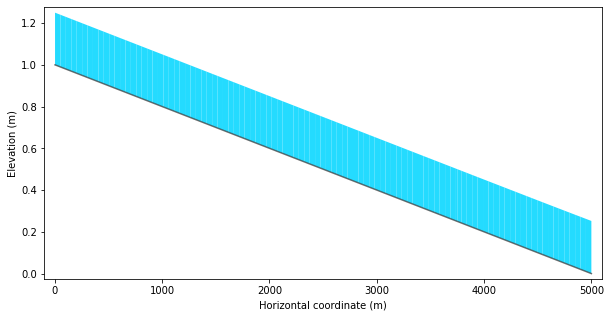

In [11]:
sns.set_palette('cool')

_ = superlink.plot_profile([0, 1])

In [12]:
dt = 60
t_span = 20 * 3600
T = t_span // dt
t_range = np.linspace(0, t_span, T)
wave = 2.0 * norm.pdf(np.linspace(-10, 10, T // 5))
Q_in_t = np.zeros((T, 2))
Q_in_t[:len(wave),0] = wave

In [13]:
_h = []
_Q = []
_A = []
t_ix = 0

while superlink.t < t_span:
    Q_in = Q_in_base + Q_in_t[t_ix]
    superlink.step(dt=dt, Q_in=Q_in)
    _h.append(superlink._h_Ik.copy())
    _Q.append(superlink._Q_ik.copy())
    _A.append(superlink._A_ik.copy())
    t_ix += 1
_h = np.vstack(_h)
_Q = np.vstack(_Q)
_A = np.vstack(_A)

Text(0.5, 1.0, 'Gaussian flow input')

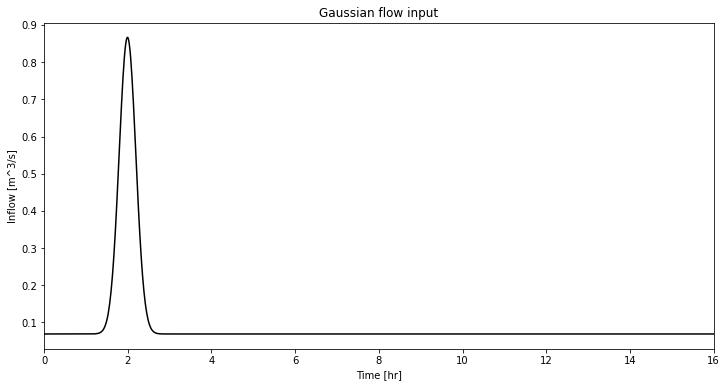

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t_range / 3600, Q_in_base[0] + Q_in_t[:,0], c='k')
ax.set_xlabel('Time [hr]')
ax.set_ylabel('Inflow [m^3/s]')
plt.xlim(0, 16)
plt.title('Gaussian flow input')

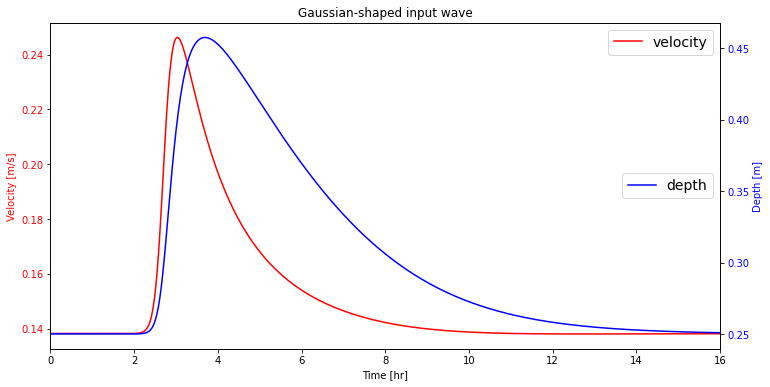

In [15]:
elem = internal_links // 2

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(t_range / 3600, _Q[:,elem] / _A[:,elem], c='r', label='velocity')
plt.legend(fontsize=14, loc='upper right')
#ax1.set_ylim(0, 0.5)
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylabel('Velocity [m/s]', color='r')
ax1.set_xlabel('Time [hr]')

ax2 = ax1.twinx()
ax2.plot(t_range / 3600, _h[:,elem], c='b', label='depth')
plt.legend(loc='right', fontsize=14)
plt.xlim(0, 16)
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel('Depth [m]', color='b')
plt.title('Gaussian-shaped input wave')

plt.savefig('velocity_depth_1.png', facecolor='white', bbox_inches='tight')

In [16]:
# Set all internal states to normal flow
superlink._h_Ik.fill(h)
superlink._Q_ik.fill(Q[0])
superlink._u_ik.fill(V[0])
superlink._u_Ik.fill(V[0])
superlink._u_Ip1k.fill(V[0])
superlink._A_ik.fill(A[0])
superlink._A_uk.fill(A[0])
superlink._A_dk.fill(A[0])
superlink._Q_uk.fill(Q[0])
superlink._Q_dk.fill(Q[0])
superlink.H_j.fill(h)
superlink._V_sj = superlink._A_sj * h

# Spin up model to stabilize
superlink.spinup(n_steps=1000, dt=60, Q_in=Q_in_base, H_bc=H_bc)

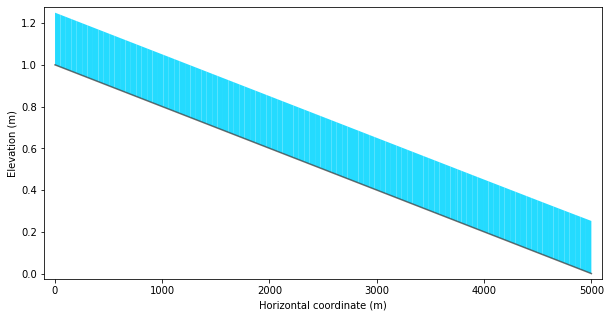

In [17]:
sns.set_palette('cool')

_ = superlink.plot_profile([0, 1])

In [18]:
Q_tri = np.hstack([np.linspace(0., 0.5, 100), np.linspace(0.5, 0., 100), 
                   np.zeros(T - 200)])
Q_tri = np.column_stack([Q_tri, np.zeros(T)])

In [19]:
_h = []
_Q = []
_A = []
t_ix = 0

while superlink.t < t_span:
    Q_in = Q_in_base + Q_tri[t_ix]
    superlink.step(dt=dt, Q_in=Q_in)
    _h.append(superlink._h_Ik.copy())
    _Q.append(superlink._Q_ik.copy())
    _A.append(superlink._A_ik.copy())
    t_ix += 1
_h = np.vstack(_h)
_Q = np.vstack(_Q)
_A = np.vstack(_A)

Text(0.5, 1.0, 'Triangle flow input')

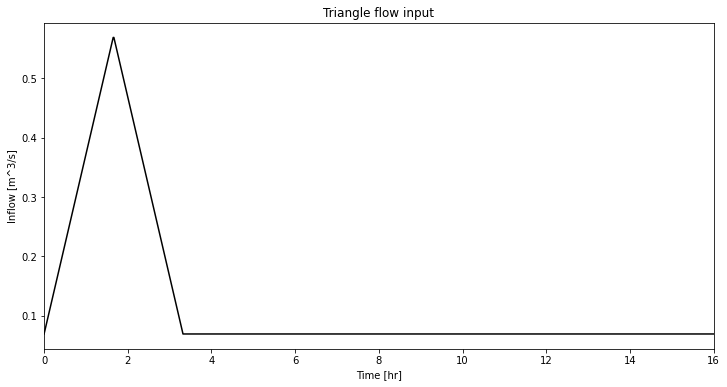

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t_range / 3600, Q_in_base[0] + Q_tri[:,0], c='k')
ax.set_xlabel('Time [hr]')
ax.set_ylabel('Inflow [m^3/s]')
plt.xlim(0, 16)
plt.title('Triangle flow input')

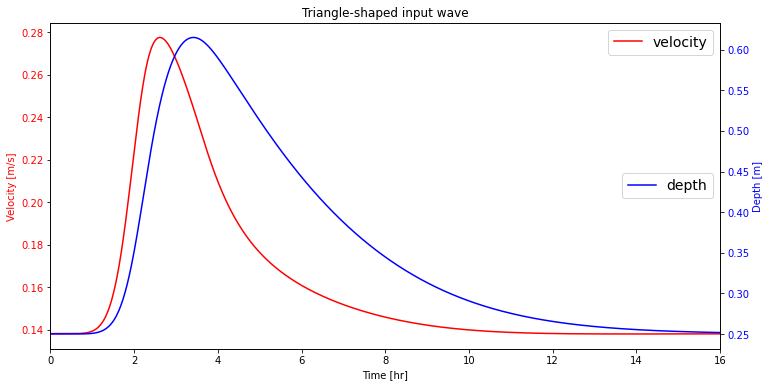

In [21]:
elem = internal_links // 2

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(t_range / 3600, _Q[:,elem] / _A[:,elem], c='r', label='velocity')
plt.legend(fontsize=14, loc='upper right')
#ax1.set_ylim(0, 0.5)
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylabel('Velocity [m/s]', color='r')
ax1.set_xlabel('Time [hr]')

ax2 = ax1.twinx()
ax2.plot(t_range / 3600, _h[:,elem], c='b', label='depth')
plt.legend(loc='right', fontsize=14)
plt.xlim(0, 16)
#ax2.set_ylim(0, 0.55)
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel('Depth [m]', color='b')
plt.title('Triangle-shaped input wave')

plt.savefig('velocity_depth_2.png', facecolor='white', bbox_inches='tight')

In [22]:
# Set all internal states to normal flow
superlink._h_Ik.fill(h)
superlink._Q_ik.fill(Q[0])
superlink._u_ik.fill(V[0])
superlink._u_Ik.fill(V[0])
superlink._u_Ip1k.fill(V[0])
superlink._A_ik.fill(A[0])
superlink._A_uk.fill(A[0])
superlink._A_dk.fill(A[0])
superlink._Q_uk.fill(Q[0])
superlink._Q_dk.fill(Q[0])
superlink.H_j.fill(h)
superlink._V_sj = superlink._A_sj * h

# Spin up model to stabilize
superlink.spinup(n_steps=1000, dt=60, Q_in=Q_in_base, H_bc=H_bc)

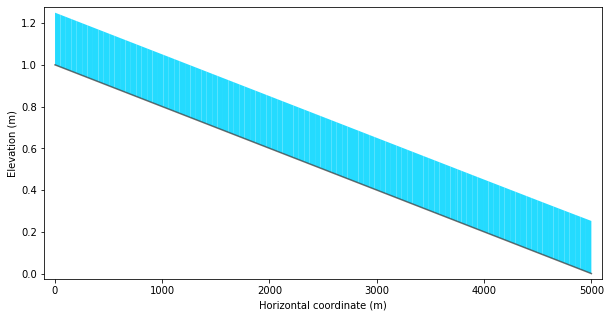

In [23]:
sns.set_palette('cool')

_ = superlink.plot_profile([0, 1])

In [24]:
Q_sin = (1 - np.cos(np.linspace(0, 8 * np.pi, T))) / 4
Q_sin = np.column_stack([Q_sin, np.zeros(T)])

In [25]:
_h = []
_Q = []
_A = []
t_ix = 0

while superlink.t < t_span:
    Q_in = Q_in_base + Q_sin[t_ix]
    superlink.step(dt=dt, Q_in=Q_in)
    _h.append(superlink._h_Ik.copy())
    _Q.append(superlink._Q_ik.copy())
    _A.append(superlink._A_ik.copy())
    t_ix += 1
_h = np.vstack(_h)
_Q = np.vstack(_Q)
_A = np.vstack(_A)

Text(0.5, 1.0, 'Sinusoidal flow input')

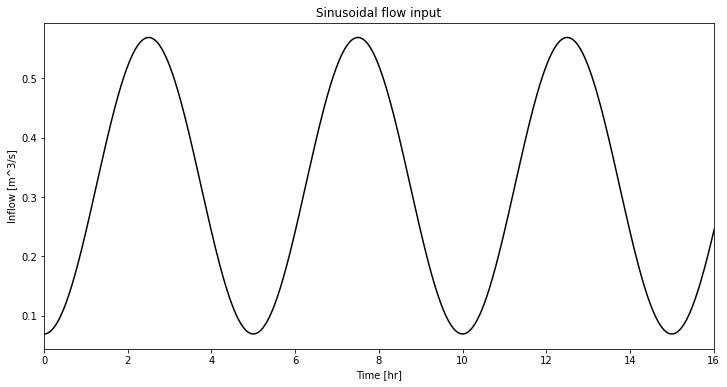

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t_range / 3600, Q_in_base[0] + Q_sin[:,0], c='k')
ax.set_xlabel('Time [hr]')
ax.set_ylabel('Inflow [m^3/s]')
plt.xlim(0, 16)
plt.title('Sinusoidal flow input')

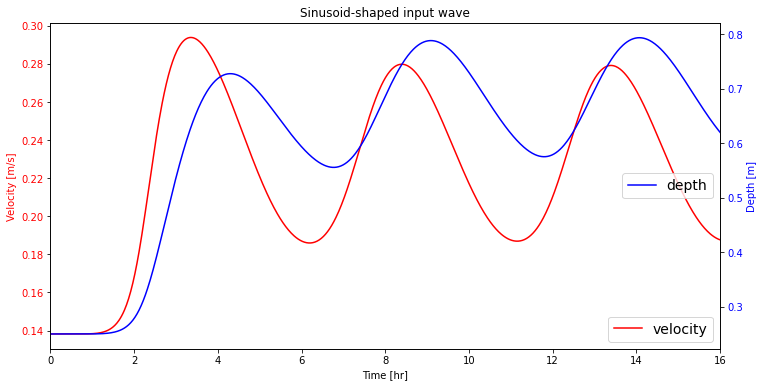

In [27]:
elem = internal_links // 2

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(t_range / 3600, _Q[:,elem] / _A[:,elem], c='r', label='velocity')
plt.legend(fontsize=14, loc='lower right')
#ax1.set_ylim(0, 0.5)
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylabel('Velocity [m/s]', color='r')
ax1.set_xlabel('Time [hr]')

ax2 = ax1.twinx()
ax2.plot(t_range / 3600, _h[:,elem], c='b', label='depth')
plt.legend(loc='right', fontsize=14)
plt.xlim(0, 16)
#ax2.set_ylim(0, 0.55)
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel('Depth [m]', color='b')
plt.title('Sinusoid-shaped input wave')

plt.savefig('velocity_depth_3.png', facecolor='white', bbox_inches='tight')